In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager as font_manager
from matplotlib.ticker import NullFormatter
import pandas as pd
import os
import torch
%matplotlib inline
import time

from matplotlib import rc
matplotlib.rcParams.update({'font.size': 15})
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True) #can't plot some basic text like _
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

In [6]:
def parse_experiment_names(name_list):
    """
    TODO: doesn't take into account location so duplicate keys are removed
    e.g. inner and outer momentum
    """
    commons = []
    parsed_name_list = [name.split('_') for name in name_list]
    clean_names = [name.split('_') for name in name_list]

    for key in parsed_name_list[0]:
        if (all([key in names for names in parsed_name_list])):
            commons.append(key)

    for idx, parsed_name in enumerate(parsed_name_list):
        for k in parsed_name:
            if k in commons:
                clean_names[idx].remove(k)

    return '_'.join(commons), ['_'.join(el) for el in clean_names]


def norm_and_std(x):
    """ x has shape (n_shedules-1, n_batches)"""
    norms = np.linalg.norm(x, axis=1)
    avg_norm = np.mean(norms)
    std = np.std(norms)
    return '{:02.2f} +/- {:02.2f}'.format(avg_norm, std)


def avg_abs_std(x):
    return '{:02.2f} +/- {:02.2f}'.format(np.mean(np.abs(x)), np.std(np.abs(x)))


def mean_and_std(x):
    return '{:02.2f} +/- {:02.2f}'.format(np.mean(x), np.std(x))

In [7]:
class ExperimentParser(object):

    def __init__(self, experiment_path):
        self.experiment_path = experiment_path
        self.logs_meta_path = os.path.join(experiment_path, 'logs_meta.pth.tar')
        self.parse_args()
        if os.path.isfile(self.logs_meta_path): self.parse_logs()

    def parse_args(self):
        args_path = os.path.join(self.experiment_path, 'args.txt')
        df = pd.read_csv(args_path, sep='\t', header=None, usecols=[0,1], names=['keys', 'values'])
        self.args = {k.strip():v.strip() for k,v in zip(df['keys'], df['values'])}


    def parse_logs(self):
        """
        hypergrads_all is saved in shape: (runs, n_chunks, n_hypers_per_chunk)
        """
        ## Meta logs
        logs_meta = torch.load(self.logs_meta_path, map_location=torch.device('cpu'))
        self.n_runs, self.n_chunks, self.n_hypers_per_chunk = logs_meta['hypergrads_all'].shape
        self.hypergrads_all = logs_meta['hypergrads_all'].view(self.n_runs, -1).numpy()
        self.n_total_hypers = self.hypergrads_all.shape[1]
        
        ## Get some common x_axis in units of batches
        self.n_total_batches = int(self.args['n_total_batches'])
        bin_size = self.n_total_batches/self.n_total_hypers # in units of batches
        half_of_first_bin = bin_size/2
        half_of_last_bin = self.n_total_batches - bin_size/2
        self.x = np.linspace(half_of_first_bin, half_of_last_bin, self.n_total_hypers)
        


def plot_single_experiment(experiment_path, fig_title=None, y_range=None):
    """
    Single experiment pointing to one folder with one hypergrads_all
    """
    fig = plt.figure(figsize=(14,7))#
    grid_params = {'linestyle': '--', 'linewidth': 1, 'alpha':1} #'axis':'y'
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)
    for ax in fig.axes: 
        ax.grid(**grid_params)
        ax.tick_params(axis='both', which='major', labelsize=20)
        
        
    exp = ExperimentParser(experiment_path)
    
    for run_idx in range(exp.n_runs): #each shedule/outer_step is a color
        r = (run_idx+1)/exp.n_runs
        color = plt.cm.rainbow(r)
        alpha = 0.8
        linewidth = 1
        ax1.plot(exp.x, exp.hypergrads_all[run_idx], color=color, alpha=alpha, linewidth=linewidth)
    
    mean = np.mean(exp.hypergrads_all, axis=0)
    ax1.plot(exp.x, mean, color='black', alpha=1, linewidth=2)
    
    
    std = np.std(exp.hypergrads_all, axis=0)
    hypervariance = std/np.abs(mean)
    
    ax2.plot(exp.x, hypervariance)
    
    if fig_title is not None:
        rc('text', usetex=False)
        fig.suptitle(fig_title, fontsize=12)
        rc('text', usetex=True)
    
    if y_range is not None:
        ax1.set_ylim(*y_range)




In [41]:
#exp_path = '/home/paul/git/GreedyGrad/logs/RHV_FashionMNIST_LeNet_nBN_ReLU_varval_nb5_nc5_nhpc-1_nruns3_tbs128_vbs128_iSGD_lr0.0_mom0.0_wd0.0_S0'
#exp_path = '/home/paul/LOCAL_logs/GreedyGrad/Hypervariance/FashionMNIST/run0_val_and_train_change/ilr0/RHV_FashionMNIST_LeNet_nBN_ReLU_nb464_nc1_nhpc-1_nruns100_tbs128_vbs128_iSGD_lr0.0_mom0.0_wd0.0_olr0.1_S0'
exp_path = '/home/paul//LOCAL_logs/GreedyGrad/Hypervariance/SVHN/CDT_local/reverse_hypervariance/SVHN/ilr0.0/normBN/2ndordFalse/exp/RHV_SVHN_LeNet_nBN_ReLU_nb470_nc1_nhpc5_nruns50_tbs128_vbs128pert-train_lr_initxavier-1.0_norm1.0_iSGD_lr0.0_mom0.9_wd0.0005_S0'
exp = ExperimentParser(exp_path)
#print(exp.args)

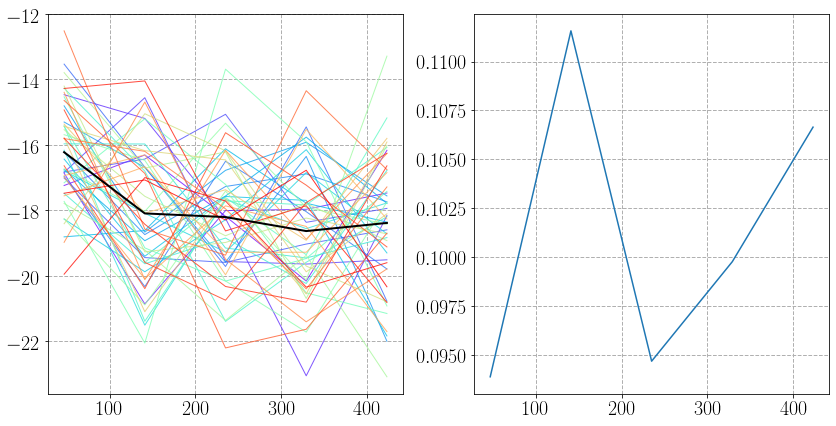

In [69]:
plot_single_experiment(exp_path)

In [218]:
len(np.array([1,2,3,4]))

4

In [8]:
def smooth_vector(x, window_len=2, window_type='hanning'):
    x = np.array(x)

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")
    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")
    if window_len<3:
        return x
    if not window_type in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")

    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window_type == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window_type+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    
    # Changed to return same size
    shape_diff = y.shape[0] - x.shape[0]
    if shape_diff % 2 == 0: 
        io, fo = int(shape_diff/2), int(shape_diff/2)
    else:
        io, fo = int(shape_diff/2), int(shape_diff/2) + 1
        
    return y[io:-fo]


def calculate_hypervariance(exp, clip_hypergrads, clip_hypervariance, 
                            smooth, smooth_window_len, smooth_window_type):
    
    
    if clip_hypergrads is not None: 
        exp.hypergrads_all = np.clip(exp.hypergrads_all, a_min=clip_hypergrads[0], a_max=clip_hypergrads[1]) 
    
    mean = np.mean(exp.hypergrads_all, axis=0)
    std = np.std(exp.hypergrads_all, axis=0)
    hypervariance = std/np.abs(mean)
    
    if clip_hypervariance is not None: 
        hypervariance = np.clip(hypervariance, a_min=clip_hypervariance[0], a_max=clip_hypervariance[1])
    
    if smooth and len(hypervariance) > 50: #only smooth experiments with lots of points (nc1, nhpc==10 excluded)
        hypervariance = smooth_vector(hypervariance, smooth_window_len, smooth_window_type)
    
    
    return hypervariance


def extract_title_from_bundle_path(bundle_path):
    """
    takes in path to bundle and returns factors we care about.
    Very ad hoc, based on experiment naming
    """
    experiment_names = []
    for name in os.listdir(bundle_path):
        if 'RHV' in name:
            experiment_names.append(name)
    
    #print(experiment_names)
    common_keys, unique_keys = parse_experiment_names(experiment_names)
    keys = common_keys.split('_')
    #print(common_keys.split('_'))
    
    
    title = ''
    for key in keys:
        if 'lr0' in key:
            title += f' {key}'
        if key=='nBN' or key=='nNone':
            title += f' {key}'
        if 'tbs' in key:
            title += f' {key}'
        if 'vtf' in key:
            title += f' {key}'
        if "grads_clamp" in key:
            title += f' {key}'
        if "first-order" in key:
            title += f' {key}'
    
    if 'wd0.0005' in keys and 'mom0.9' in keys:
        title += ' REG'
    
    
    return title
    
        
def plot_experiment_bundle(path_to_exp_bundle,
                           clip_hypergrads=None,
                           clip_hypervariance=None,
                           smooth=False,
                           smooth_window_len=10,
                           smooth_window_type='hanning'):
    """
    A bundle is a folder containing all experiments to go in figure 2.
    This includes [train, val, weight, lr] perturbations,
    and nhpcs=(1, 5) and nc=(1, -1). Not all files need to be there.
    
    clip_hyper* = None or (min,max) tuple
    """
    
    ## Create Figure
    fig = plt.figure(figsize=(21,7))#
    grid_params = {'linestyle': '--', 'linewidth': 1, 'alpha':1} #'axis':'y'
    ax1, ax2, ax3, ax4 = [fig.add_subplot(1, 4, i) for i in range(1,5)]
    for ax in fig.axes: 
        ax.grid(**grid_params)
        ax.tick_params(axis='both', which='major', labelsize=20)
    perturbs = ['train', 'val', 'weights', 'hypers']
    
    for (perturb, ax) in zip(['pert-train', 'pert-val', 'pert-weights', 'pert-hypers'], fig.axes):
        ax.set_title(perturb)
    
    title = extract_title_from_bundle_path(path_to_exp_bundle)
    ax1.set_ylabel(title, fontsize=25)
        
    
    ## Plot All Experiments in Bundle
    failed_exps = 0
    for exp_folder_name in os.listdir(path_to_exp_bundle):
        exp_folder_path = os.path.join(path_to_exp_bundle, exp_folder_name)
        exp = ExperimentParser(exp_folder_path)
        pert, nc, nhpc, nb, ilr, norm, mom, wd, tbs, vtf = exp.args['perturb'], float(exp.args['n_chunks']), float(exp.args['n_hypers_per_chunk']), float(exp.args['n_total_batches']), float(exp.args['inner_lr_init']), exp.args['norm_type'], float(exp.args['inner_mom_init']), float(exp.args['inner_wd_init']), float(exp.args['train_batch_size']), float(exp.args['val_train_fraction'])
        
        
        if os.path.isfile(os.path.join(exp_folder_path, 'logs_meta.pth.tar')):
            assert pert in perturbs
            
            hypervariance = calculate_hypervariance(exp, 
                                                    clip_hypergrads,
                                                    clip_hypervariance,
                                                    smooth,
                                                    smooth_window_len,
                                                    smooth_window_type)
            
            ax = fig.axes[perturbs.index(pert)]
            
            if nc==1:
                if nhpc==nb:
                    ax.plot(exp.x, hypervariance, color='red', label=f'nc{nc} nhpc{nhpc}')
                else:
                    ax.plot(exp.x, hypervariance, color='green', label=f'nc{nc} nhpc{nhpc}')
            else:
                ax.plot(exp.x, hypervariance, color='blue', label=f'nc{nc} nhpc{nhpc}')
                
            
        else:
            failed_exps += 1
            print(f'Incomplete exp: pert-{pert} nc{nc} nhpc{nhpc} in bundle {title}')
        
    return failed_exps
     

def get_exp_bundles(master_folder):
    """Get exp bundle folders' path"""
    exp_bundles_paths = []
    for root, directories, filenames in os.walk(master_folder):
        for directory in directories:
            if directory.endswith('exp'):
                #if 'normNone' not in root: #exclude no norm runs since they all suck
                exp_bundles_paths.append(os.path.join(root, directory))
    return exp_bundles_paths
                        
                        
def plot_all_bundles(path_to_master_folder, 
                     clip_hypergrads=None,
                     clip_hypervariance=None,
                     smooth=False,
                     smooth_window_len=10,
                     smooth_window_type='hanning'):
    """
    Plot all bundles over a tree structure where each experiment
    is a sub folder called 'exp'
    """
    
    exp_bundles_paths = get_exp_bundles(path_to_master_folder)
    total_failed_experiments = 0
    for exp_bundle_path in exp_bundles_paths:
        bundle_failed_exps = plot_experiment_bundle(exp_bundle_path,
                                                    clip_hypergrads=clip_hypergrads,
                                                    clip_hypervariance=clip_hypervariance,
                                                    smooth=smooth,
                                                    smooth_window_len=smooth_window_len,
                                                    smooth_window_type=smooth_window_type)
        total_failed_experiments += bundle_failed_exps
    
    print(f'\n-----TOTAL INCOMPLETE EXPERIMENTS: {total_failed_experiments}-----')
    

Incomplete exp: pert-val nc400.0 nhpc1.0 in bundle  nNone tbs64 vtf0.2 lr0.05
Incomplete exp: pert-val nc400.0 nhpc1.0 in bundle  nNone tbs64 vtf0.2 lr0.05

-----TOTAL INCOMPLETE EXPERIMENTS: 2-----


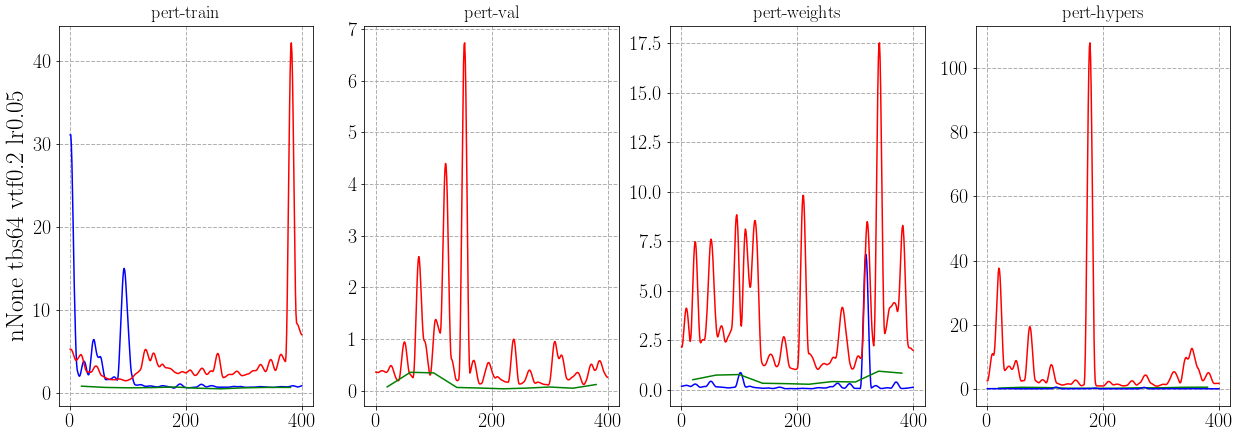

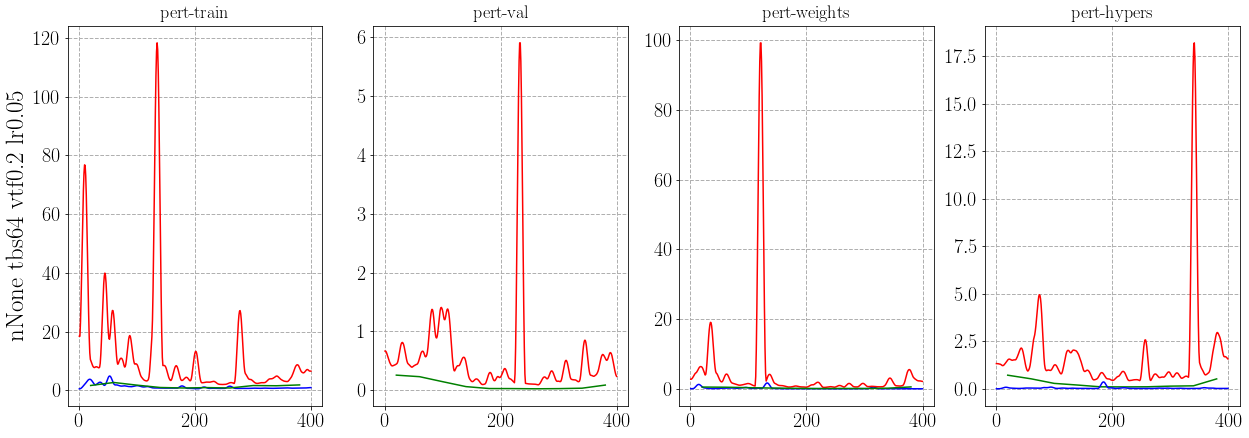

In [248]:
#TODO: PLOT WD AND MOM
#master_folder = '/home/paul/LOCAL_logs/GreedyGrad/Hypervariance/SVHN/CDT_local_v1'
#master_folder = '/home/paul/LOCAL_logs/GreedyGrad/Hypervariance/SVHN/CDT_local_v2'
#master_folder = '/home/paul/LOCAL_logs/GreedyGrad/Hypervariance/SVHN/CDT_local_v3'
master_folder = '/home/paul/LOCAL_logs/GreedyGrad/Hypervariance/SVHN/HYPERVARIANCE_FINAL'

plot_all_bundles(master_folder, 
                 clip_hypergrads=None,#(-1,1),
                 clip_hypervariance=(0,1000),
                 smooth=True,
                 smooth_window_len=20,
                 smooth_window_type='hanning')
                 

# Figure

In [71]:
def make_figure2(path_to_exp_bundle,
                 clip_hypergrads=None,
                 clip_hypervariance=None,
                 smooth=False,
                 smooth_window_len=10,
                 smooth_window_type='hanning',
                 plot_y_lims=(-0.5,20),
                 y_ticks_lims=(0,20),
                 plot_n_ticks=4):
    """
    A bundle is a folder containing all experiments to go in figure 2.
    This includes [train, val, weight, lr] perturbations,
    and nhpcs=(1, 5) and nc=(1, -1). Not all files need to be there.
    
    clip_hyper* = None or (min,max) tuple
    """
    
#     title_size = 25
#     title_y = 1.05
#     label_size = 25
#     legend_size = 20
#     tick_size = 20
#     linewidth = 2.5
    
    title_size = 31
    title_y = 1.05
    linewidth = 2.5
    label_size = 31
    legend_size = 31
    tick_size = 31
    
#     color1 = 'tab:blue'
#     color2 = 'tab:red'
#     color3 = 'tab:green'
    
#     color1 = '#377eb8' # blue
#     color2 = '#ff7f00' # green 
#     color3 = '#4daf4a' # orange '', '', '', '', '', ''
    
#     color1 = '#f781bf' # pink
#     color2 = '#a65628' # brown
#     color3 = '#984ea3' #purple keep
    
#     color1 = '#999999' # grey
#     color2 = '#e41a1c' # red keep
#     color3 = '#dede00' # yellow
    
    color1 = '#377eb8' #blue
    color2 = '#e41a1c'
    color3 = '#984ea3'
    
    
    ## Create Figure
    fig = plt.figure(figsize=(21,7))#
    grid_params = {'axis':'y', 'linestyle': '--', 'linewidth': 1, 'alpha':0.5}
    ax1, ax2, ax3, ax4 = [fig.add_subplot(1, 4, i) for i in range(1,5)]
    for ax in fig.axes: 
        ax.grid(**grid_params)
        ax.tick_params(axis='both', which='major', labelsize=tick_size)
        ax.set_ylim(plot_y_lims)    
        ax.yaxis.set_ticks(np.arange(y_ticks_lims[0],y_ticks_lims[1], plot_n_ticks))
        ax.xaxis.set_ticks((0,150,300))
        if ax!=ax1: ax.yaxis.set_major_formatter(NullFormatter())
        ax.set_xlabel('steps', size=label_size)
        
    ax1.set_ylabel(r'hypervariance', size=label_size)
    perturbs = ['train', 'val', 'weights', 'hypers']
    plt.subplots_adjust(wspace=0.03, hspace=0)
    #plt.gcf().subplots_adjust(bottom=0.15)
    
    for (perturb, ax) in zip([r'$\mathcal{D}_{train}$', '$\mathcal{D}_{val}$', r'$\boldsymbol{\theta}$', r'$\boldsymbol{\alpha}$'], fig.axes):
        ax.set_title(perturb, position=(0.5, title_y), fontsize=title_size)
    
    ## Plot All Experiments in Bundle
    for exp_folder_name in os.listdir(path_to_exp_bundle):
        exp_folder_path = os.path.join(path_to_exp_bundle, exp_folder_name)
        exp = ExperimentParser(exp_folder_path)
        pert, nc, nhpc, nb, ilr, norm, mom, wd, tbs, vtf = exp.args['perturb'], float(exp.args['n_chunks']), float(exp.args['n_hypers_per_chunk']), float(exp.args['n_total_batches']), float(exp.args['inner_lr_init']), exp.args['norm_type'], float(exp.args['inner_mom_init']), float(exp.args['inner_wd_init']), float(exp.args['train_batch_size']), float(exp.args['val_train_fraction'])
        
        
        if os.path.isfile(os.path.join(exp_folder_path, 'logs_meta.pth.tar')):
            assert pert in perturbs
            
            hypervariance = calculate_hypervariance(exp, 
                                                    clip_hypergrads,
                                                    clip_hypervariance,
                                                    smooth,
                                                    smooth_window_len,
                                                    smooth_window_type)
            
            ax = fig.axes[perturbs.index(pert)]
            
            if nc==1:
                if nhpc==nb:
                    ax.plot(exp.x, hypervariance, color=color1, label='non-greedy', linewidth=linewidth)
                else:
                    ax.plot(exp.x, hypervariance, color=color3, label='non-greedy \n+ shared', linewidth=linewidth)
            else:
                ax.plot(exp.x, hypervariance, color=color2, label='greedy', linewidth=linewidth)
    
    ax2.legend(prop={'size': legend_size})
    fig.savefig("hypervariance.pdf", bbox_inches='tight');

In [72]:
exp_path = '/home/paul/LOCAL_logs/GreedyGrad/Hypervariance/SVHN/HYPERVARIANCE_FINAL/seed1/exp'

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


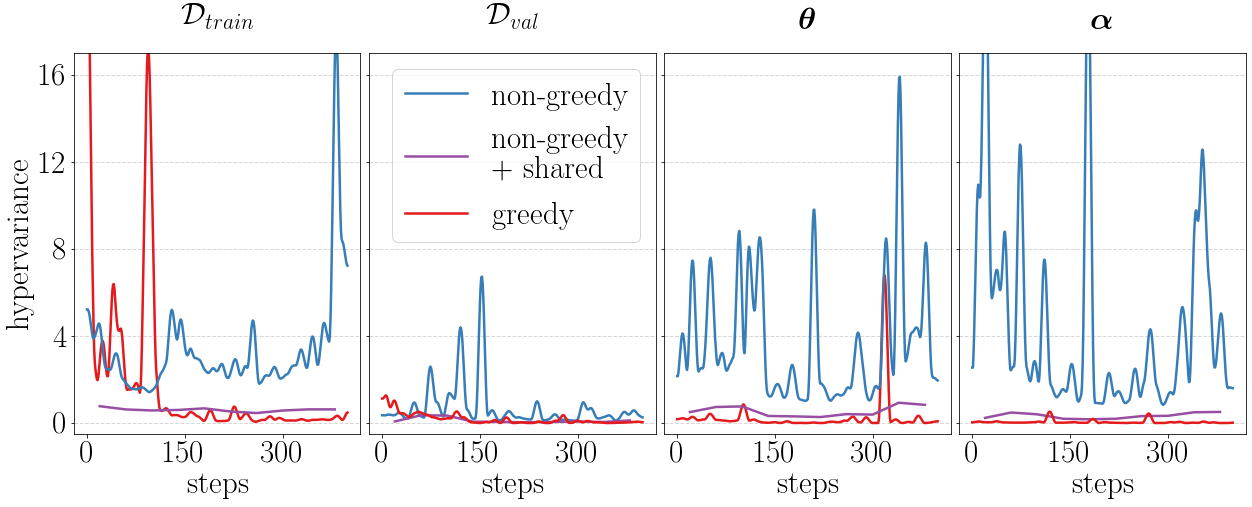

In [73]:
make_figure2(exp_path,
             clip_hypergrads=(-1,1),
             clip_hypervariance=(0,100),
             smooth=True,
             smooth_window_len=20,
             smooth_window_type='hanning',
             plot_y_lims=(-0.5,17),
             y_ticks_lims=(0,17),
             plot_n_ticks=4)